# Task 4 Explorative Data Analysis
## Group 03
04 January 2019

In [1]:
import time
print(time.asctime())

Mon Jan  7 09:48:03 2019


In [2]:
import sys
print(sys.version)

3.6.7 |Anaconda, Inc.| (default, Oct 28 2018, 19:44:12) [MSC v.1915 64 bit (AMD64)]


In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as st
import glob
import os
import matplotlib.pyplot as plt

import warnings
import statsmodels as sm
import matplotlib


In [4]:
# so we don't have to do plt.show() every time
%matplotlib inline

**TODO: repeat the analysis below for 2014_LSC_A2.csv**

In [5]:
adf = pd.read_csv("2014_LSC_A2.csv")
adf_plot = adf.loc[:,["image_ID", "size", "roundness", "brightness_average_green","feret_ratio", "width_to_height_ratio"]]
adf_plot.head()

,image_ID,size,roundness,brightness_average_green,feret_ratio,width_to_height_ratio
0,plant001_rgb_class_watershed,155,0.807,158.909677,0.788932,1.000000
1,plant001_rgb_class_watershed,161,0.735,159.012422,0.730091,0.875000
2,plant002_rgb_class_watershed,361,0.873,167.720222,0.828233,0.954545
3,plant002_rgb_class_watershed,212,0.934,160.108491,0.871576,1.062500
4,plant002_rgb_class_watershed,225,0.957,165.986667,0.925839,1.000000


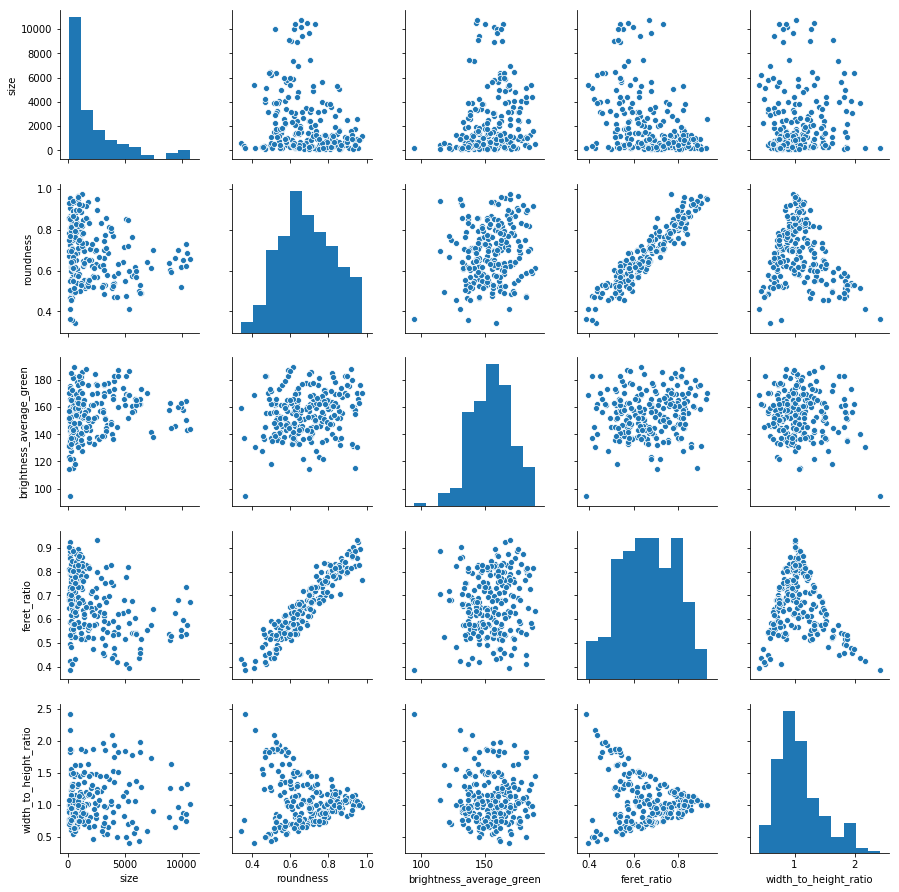

In [6]:
sns.pairplot(adf_plot)

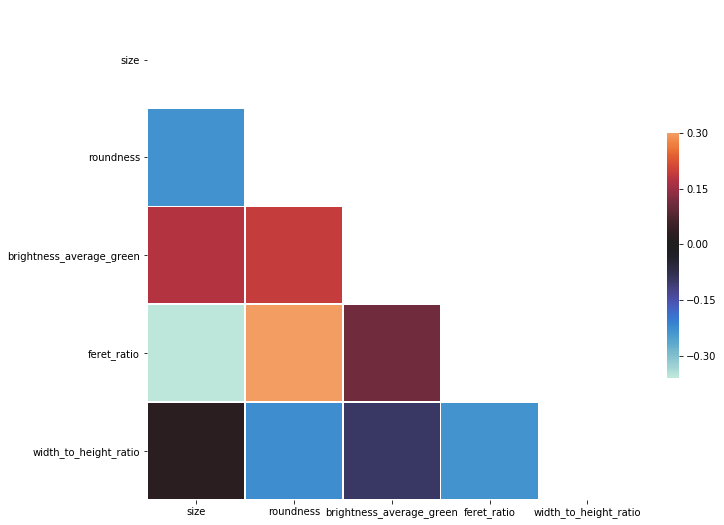

In [7]:
corr = adf_plot.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11,9))

sns.heatmap(corr, mask=mask, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

**Does the size of a leaf relate to its roundness?**

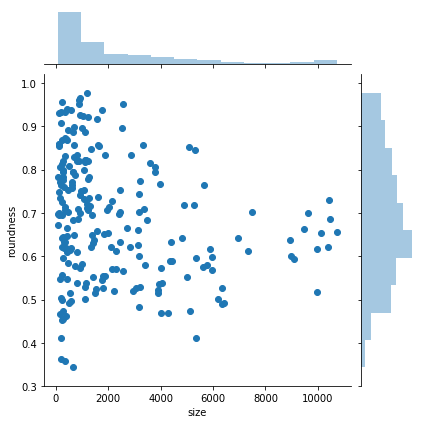

In [8]:
sns.jointplot(x="size", y="roundness", data=adf_plot.loc[:,["size","roundness"]]);

No, the size of a leaf is not correlated to its roundness. The Pearson correlation coefficient for this dataset is -0.23. 


**Does the size of a leaf relate to its color?**

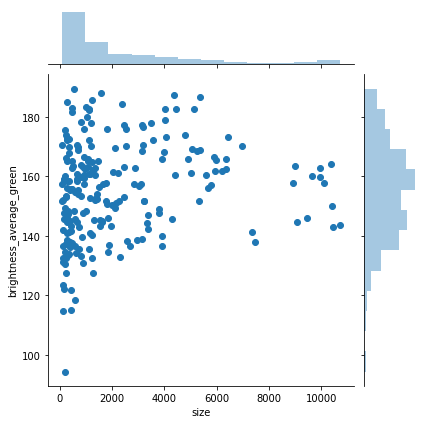

In [9]:
sns.jointplot(x="size", y="brightness_average_green", data=adf_plot.loc[:,["size","brightness_average_green"]])

The size of a leaf is not correlated to the average brightness of the green channel. The Pearson correlation coefficient is 0.18

**Is the number of leaves per plant correlated to the total leaf area?**

In [10]:
# number of objects for each image_ID
aid_df = adf_plot.groupby("image_ID").size()

# sum of size of objects for each image_ID
aarea_df = adf_plot.groupby("image_ID")["size"].agg("sum")

aid_area_df = aid_df.to_frame().join(aarea_df.to_frame())

aid_area_df.rename(columns={aid_area_df.columns[0] : "num_leaves"}, inplace=True)

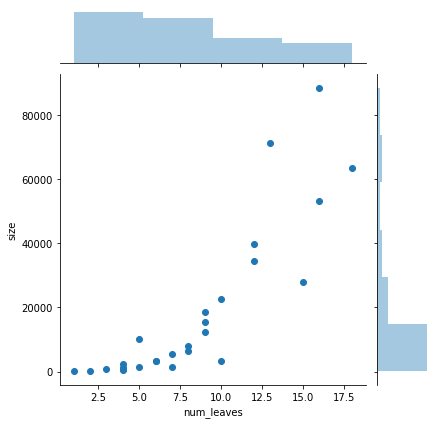

SpearmanrResult(correlation=0.9432544019967781, pvalue=5.831099082653899e-14)


In [11]:
sns.jointplot(x="num_leaves", y="size", data=aid_area_df) #.loc[:,["num_leaves", "size"]])
plt.show()

spear_corr = st.spearmanr(aid_area_df.loc[:,"num_leaves"], aid_area_df.loc[:,"size"])
print(spear_corr)

The number of leaves is highly correlated to the total leaf area. The Pearson correlation coefficient is 0.86, and the Spearman Rank Coefficient is approximately 0.94. The Pearson correlation coefficient only captures linear relationships, whereas the Spearman coefficient can measure non-linear correlations. In our case, the Spearman coefficient seems to better describe the relationship.

### Comparison of 2014 A1 and A2 datasets

In [14]:
# Dataframes for 2014 A1 data and 2014 A2 data
df2014A1 = pd.concat([pd.read_csv(fp).assign(file=os.path.splitext(fp)[0]) 
                for fp in glob.glob(os.path.join('',"2014_*_A1.csv"))])

df2014A2 = pd.concat([pd.read_csv(fp).assign(file=os.path.splitext(fp)[0]) 
                for fp in glob.glob(os.path.join('',"2014_*_A2.csv"))])


df2014A1_red = df2014A1.loc[:,["file","image_ID", "size", "roundness", "brightness_average_green","feret_ratio", "width_to_height_ratio"]]

df2014A2_red = df2014A2.loc[:,["file","image_ID", "size", "roundness", "brightness_average_green","feret_ratio", "width_to_height_ratio"]]

In [15]:
df2014A1_red.head()

,file,image_ID,size,roundness,brightness_average_green,feret_ratio,width_to_height_ratio
0,2014_LSC_A1,plant001_rgb_class_watershed,2328,0.487,152.213918,0.466627,0.473118
1,2014_LSC_A1,plant001_rgb_class_watershed,4048,0.826,160.503953,0.713056,1.186667
2,2014_LSC_A1,plant001_rgb_class_watershed,2032,0.577,160.130413,0.592335,1.054545
3,2014_LSC_A1,plant001_rgb_class_watershed,1650,0.617,147.095152,0.629808,0.822581
4,2014_LSC_A1,plant001_rgb_class_watershed,1121,0.614,160.175736,0.632520,1.315789


In [16]:
df2014A2_red.head()

,file,image_ID,size,roundness,brightness_average_green,feret_ratio,width_to_height_ratio
0,2014_LSC_A2,plant001_rgb_class_watershed,155,0.807,158.909677,0.788932,1.000000
1,2014_LSC_A2,plant001_rgb_class_watershed,161,0.735,159.012422,0.730091,0.875000
2,2014_LSC_A2,plant002_rgb_class_watershed,361,0.873,167.720222,0.828233,0.954545
3,2014_LSC_A2,plant002_rgb_class_watershed,212,0.934,160.108491,0.871576,1.062500
4,2014_LSC_A2,plant002_rgb_class_watershed,225,0.957,165.986667,0.925839,1.000000


**General overview over the two datasets.**

In [17]:
df2014A1_red.describe()

,size,roundness,brightness_average_green,feret_ratio,width_to_height_ratio
count,2405.000000,2405.000000,2405.000000,2405.000000,2405.000000
mean,2300.169231,0.683580,152.157593,0.661207,1.064216
std,1919.748841,0.131106,15.184565,0.113540,0.340877
min,70.000000,0.214000,97.619565,0.265739,0.361111
25%,736.000000,0.588000,143.444662,0.579048,0.814815
50%,1787.000000,0.686000,154.644115,0.667736,1.012500
75%,3576.000000,0.778000,163.305832,0.747175,1.256098
max,13488.000000,0.995000,186.737130,0.923276,3.125000


In [18]:
df2014A2_red.describe()

,size,roundness,brightness_average_green,feret_ratio,width_to_height_ratio
count,227.000000,227.000000,227.000000,227.000000,227.000000
mean,2193.229075,0.688075,155.158879,0.666387,1.078050
std,2512.367610,0.140233,16.132569,0.124543,0.362589
min,88.000000,0.343000,94.401914,0.387541,0.407143
25%,430.500000,0.581000,144.031501,0.570706,0.814815
50%,1155.000000,0.695000,156.080275,0.667491,1.000000
75%,3160.500000,0.795000,165.759380,0.771416,1.261791
max,10717.000000,0.978000,189.489091,0.931196,2.416667


The 2014 A1 and A2 datasets are fairly similar with respect to roundness, brightness_average_green, feret ratio, and width-to-height ratio. However, the size of objects in A2 seems to have a much wider distribution. This aligns with our visual inspection of the datasets; the plants in A2 range from very small to very large.

From these values, we cannot draw the conclusion whether the difference is due to wildtype versus mutant, because the documentation does not provide information about the age of the plant. In order to classify, we would need to control for age.

We inspect the "size" variable further with a kernel density estimate and histogram.

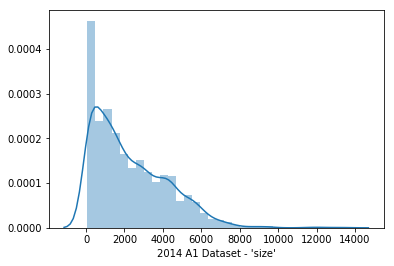

In [19]:
sns.distplot(df2014A1_red["size"], axlabel="2014 A1 Dataset - 'size'")

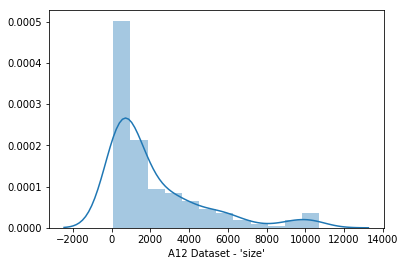

In [20]:
sns.distplot(df2014A2_red["size"], axlabel="A12 Dataset - 'size'")

These distributions do not appear to be normal. To verify this, we do a two-tailed t-test, with $H_0$ that the distribution is normal. 

In [21]:
print("A1: ", st.normaltest(df2014A1_red["size"]))

print("A2: ", st.normaltest(df2014A2_red["size"]))

A1:  NormaltestResult(statistic=375.31687551872864, pvalue=3.169392300335088e-82)
A2:  NormaltestResult(statistic=79.04635801563494, pvalue=6.843865243277433e-18)


For each, since $p<0.5$, we reject the null hypothesis and conclude that the distribution is not normal.

Moreover, the distributions appear distinct from each other. We test this with the Kolmogorov-Smirnov test. The null hypothesis $H_0$ is that the distributions are the same.

In [22]:
st.ks_2samp(df2014A1_red["size"], df2014A2_red["size"])

Ks_2sampResult(statistic=0.15457151492393784, pvalue=8.314559193561194e-05)

Since $p<0.5$, we reject the null hypothesis, and conclude that the distributions are different.

We would like to know what the underlying distribution for each variable is, so we fit a variety of distributions and select the one with minimum sum of squared error (SSE).

In [23]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [st.alpha, st.betaprime, st.burr, st.erlang, st.exponnorm, st.f, 
                     st.fisk, st.frechet_r, st.gamma, st.genextreme, st.gengamma, 
                     st.gilbrat, st.gumbel_r, st.invgamma, st.invgauss, st.invweibull, 
                     st.lognorm, st.mielke, st.ncf, st.pareto, st.recipinvgauss, st.wald]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf
    
    sses = {}

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                sses[distribution] = sse

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params, sses)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

Text(0, 0.5, 'Frequency')

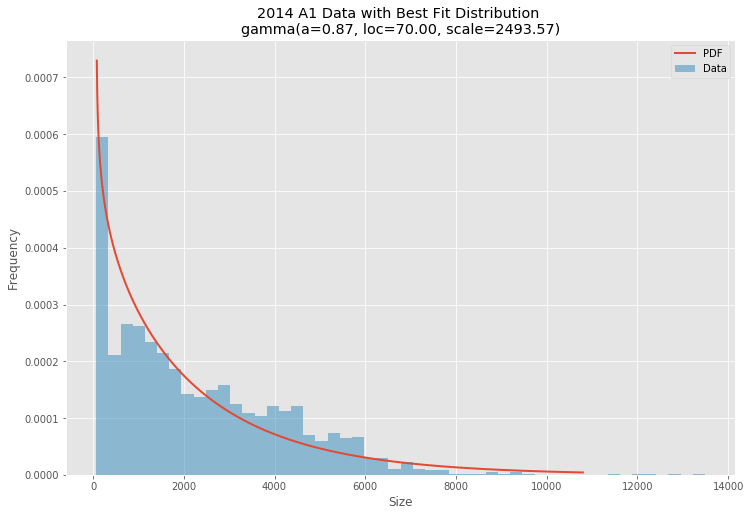

In [27]:
# For 2014 A1 "size" data
data = df2014A1_red["size"]

# Find best fit distribution
best_fit_name, best_fit_params, sses1 = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

sorted_sses1 = sorted(sses1, key=sses1.get)

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'2014 A1 Data with Best Fit Distribution \n' + dist_str)
ax.set_xlabel(u'Size')
ax.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

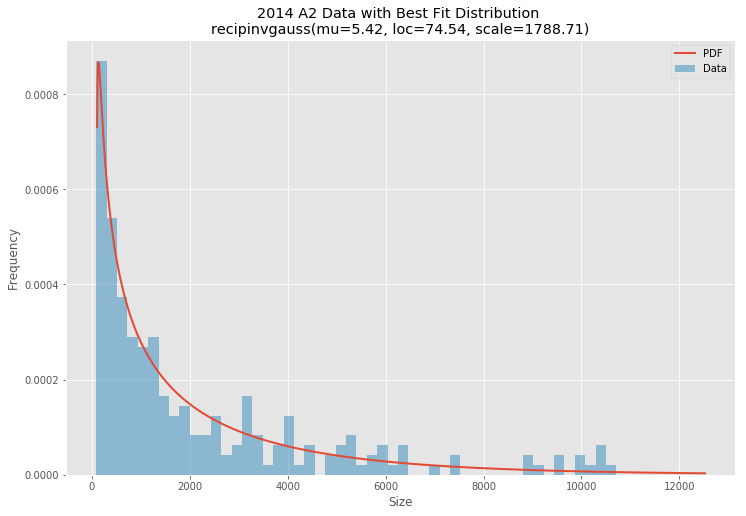

In [26]:
# For 2014 A2 "size" data
data = df2014A2_red["size"]

# Find best fit distribution
best_fit_name, best_fit_params, sses1 = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

sorted_sses1 = sorted(sses1, key=sses1.get)

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'2014 A2 Data with Best Fit Distribution \n' + dist_str)
ax.set_xlabel(u'Size')
ax.set_ylabel('Frequency')